Dataset : The dataset is a combination of 74,681 views from different people in Twitter media which includes 4 columns

1. Index : which indicates a number for each sample (not important)
2. Borderlands : which indicates a number of areas for each sample
3. Mode : The feeling of that person about the text which has shared
4. Text : The texture that view that person has shared.

In [ ]:
! pip install spacy

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import random

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
import warnings

nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'tensorflow'

In [4]:
df = pd.read_csv('D:/MSc/SEMESTER 3/NLP/twitter_training.csv')
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df.shape

(74681, 4)

In [6]:
df.isnull().sum()

2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64

In [7]:
df.describe(include = 'all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,TomClancysRainbowSix,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


# **EDA**

In [8]:
df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode'
                   , "im getting on borderlands and i will murder you all ,": 'Tweets'}, inplace=True)

In [9]:
df.head(100)

,Index,Land,Mode,Tweets
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
95,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...
96,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...
97,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t..."
98,2417,Borderlands,Negative,Grounded almost looked pretty cool here despit...


In [10]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values ,
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [11]:
show_details(df)

,Index,Land,Mode,Tweets
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


In [12]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,Index,Land,Mode,Tweets
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [13]:
print(f'The number of unique lands : {len(df.Land.unique())}')

df.Land.unique()

The number of unique lands : 32


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [14]:
lands =df.Land.value_counts()
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


C:\Users\noelm\AppData\Local\Temp\ipykernel_700\1137472092.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')


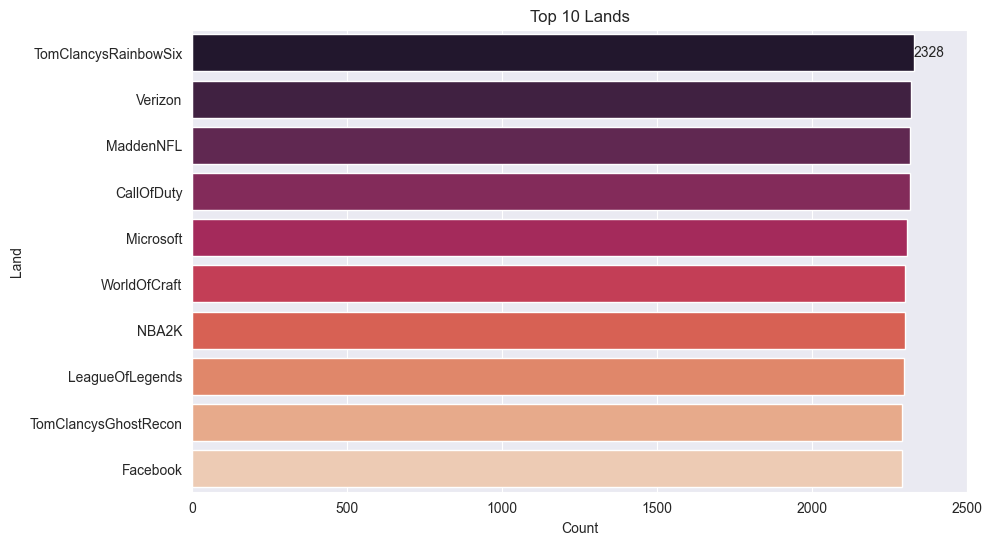

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

In [16]:
print(f'The unique values of Mode : {len(df.Mode.unique())}')
print(df.Mode.unique())

The unique values of Mode : 4
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [17]:
mode = df.Mode.value_counts()
mode.to_frame().T

Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19712,17708,12537


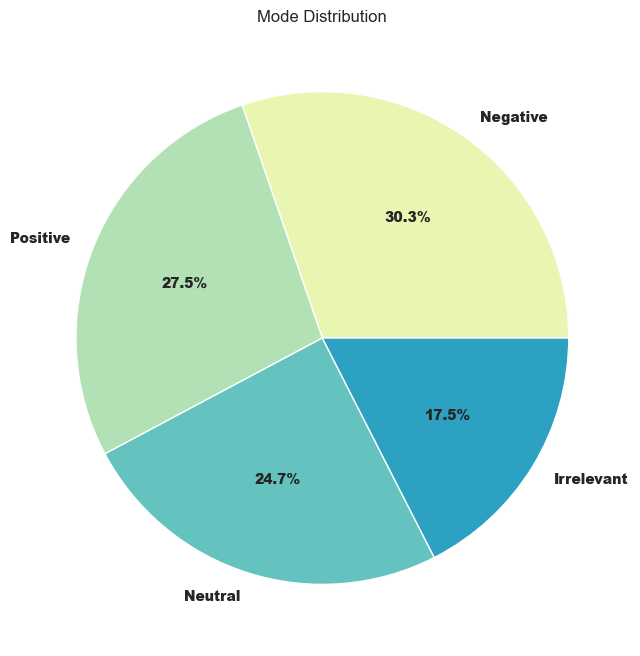

In [18]:
plt.figure(figsize=(10,8))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" ,
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("YlGnBu"))
plt.title('Mode Distribution')
plt.show()

In [19]:
pd.crosstab(df.Mode , df.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='BuGn')


Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,971
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


 - Here with re library we can replace a number of grammatically problems , verbal expressions.
 - Finally , all texts become lower mode and instead more than 1 space be just 1 space

In [20]:
def text_cleaner(tx):

    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)

    return text

<>:23: SyntaxWarning: invalid escape sequence '\S'
<>:23: SyntaxWarning: invalid escape sequence '\S'
C:\Users\noelm\AppData\Local\Temp\ipykernel_700\3340526978.py:23: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)


**POS:**
POS or Part Of Speech , the part of speech indicates how the word functions in meaning as well as grammatically within the sentence.
There are 8 parts in English (noun, pronoun, verb, adjective, adverb, preposition, conjunction, and interjection)
Understanding parts of speech is essential for determining the correct definition of a word when using the dictionary.

**Description**
with using of Spacy library and its amazing features (nlp = spacy.load("en_core_web_sm")) which is used for English language
I am going to show you POS in the particular sample

In [21]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['Mode']==kind]['Tweets'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

[nltk_data] Error loading stopwords: <urlopen error [WinError 10013]
[nltk_data]     An attempt was made to access a socket in a way
[nltk_data]     forbidden by its access permissions>


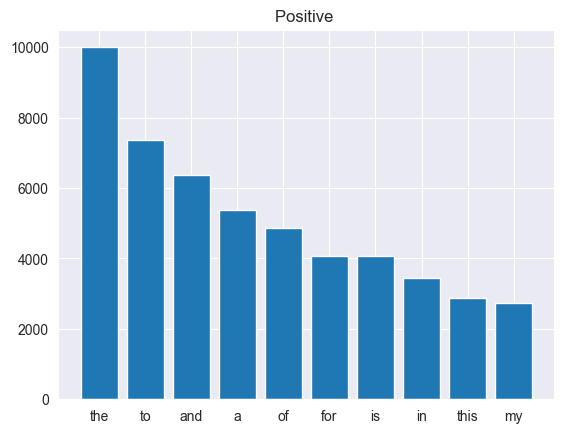

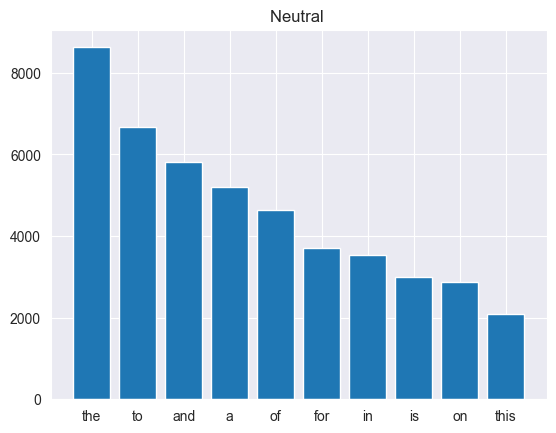

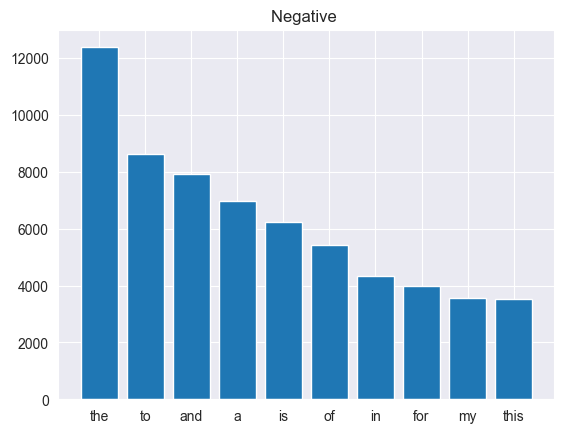

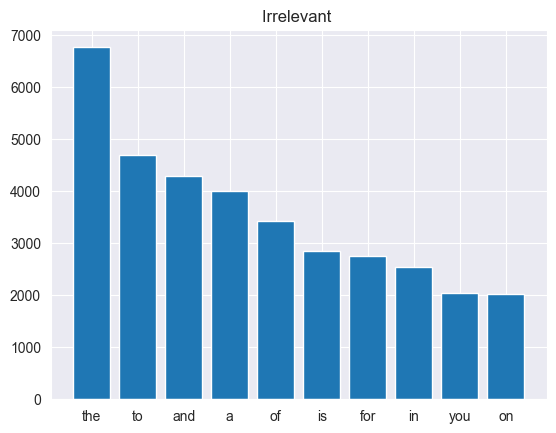

CPU times: total: 3.75 s
Wall time: 1min 29s


In [22]:
%%time
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())



for inx , value in enumerate(sentiments):

    corpus = make_corpus(value)

    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top)
    plt.title(f'{value} ')
    plt.bar(x , y)
    plt.show()

In [ ]:
# # df['Text'] = df['Text'].apply(lambda x : clean_emoji(x))
# Tokenizer=RegexpTokenizer(r'\w+')
# df['Tweets'] = df['Tweets'].apply(lambda x : text_cleaner(x))
# df['Tweets']= df['Tweets'].apply(lambda x : Tokenizer.tokenize(x))
# df['Tweets'].to_frame()

**Descripton**
A number of fundamental statistics are shown below to know about corpus .such as , maximum , minimum length of texts ,
mean of length , std and the last calculation which is momentous is the number of words which we are required to have for each sample
we should not allow all words of each sample be in the review).For example, someone has a review with 797 words. so it is computiationally expensive and furthermore , it dosent allow our model to learn perfectly.Instead of all words , we are going to use a formula to keep 95% of data , but
with a samller amount of data for learning better and instead of those additional words we use a special character namely PAD becuase all sample
should have the same length. here , Mew + 2 sigma is 165.7 which we are going to use 166 words of each sample.

In [23]:

len_text = [len(tx) for tx in df['Tweets'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 957
Min Length : 1
Mean Length : 110.54
Std Length : 79.41
Mew + 2sigma : 269.36


In [24]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

Stemmer = PorterStemmer()

# Define the regular expression pattern to match non-alphanumeric characters
pattern = r'[^a-zA-Z0-9\s]'

# Assuming stopwords_list is defined or imported elsewhere in your code
stopwords_list = set(stopwords.words('english'))

def stopwords_cleaner(text, stopwords_list):
    # Remove symbols using regular expression substitution
    text = re.sub(pattern, '', text)
    # Stemming and removing stopwords
    words = [Stemmer.stem(word) for word in text.split() if word not in stopwords_list]
    cleaned_text = ' '.join(words)
    return cleaned_text

# Assuming df['tweets'] contains the text data you want to clean
# Apply the stopwords_cleaner function to the 'tweets' column of the DataFrame
# Make sure to pass the stopwords_list as an argument
df['Tweets'] = df['Tweets'].apply(lambda x: stopwords_cleaner(x, stopwords_list))
df


,Index,Land,Mode,Tweets
0,2401,Borderlands,Positive,i come border i kill
1,2401,Borderlands,Positive,im get borderland kill
2,2401,Borderlands,Positive,im come borderland murder
3,2401,Borderlands,Positive,im get borderland 2 murder
4,2401,Borderlands,Positive,im get borderland murder
...,...,...,...,...
74676,9200,Nvidia,Positive,just realiz window partit mac like 6 year behi...
74677,9200,Nvidia,Positive,just realiz mac window partit 6 year behind nv...
74678,9200,Nvidia,Positive,just realiz window partit mac 6 year behind nv...
74679,9200,Nvidia,Positive,just realiz window partit mac like 6 year behi...


<timed exec>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



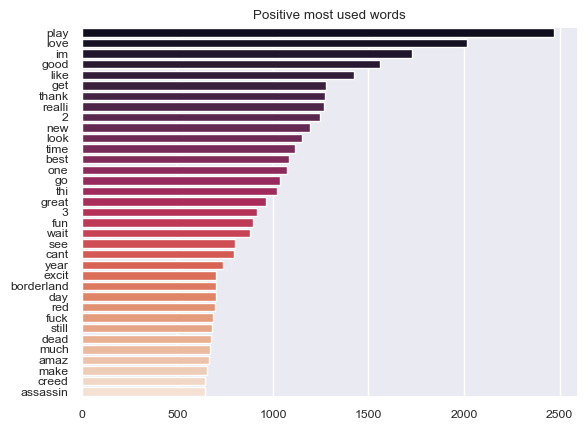

<timed exec>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



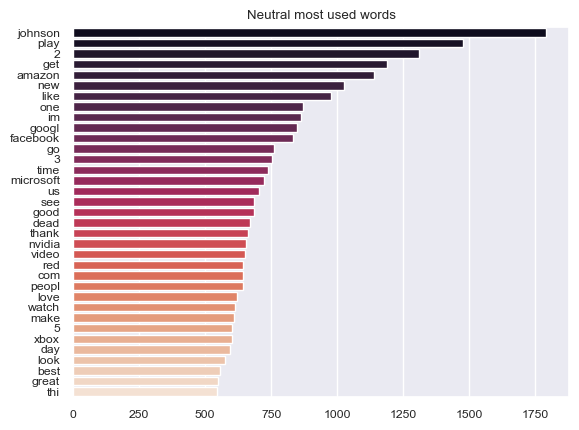

<timed exec>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



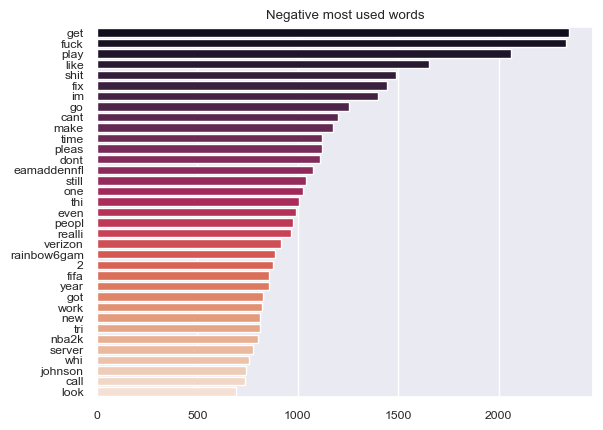

<timed exec>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



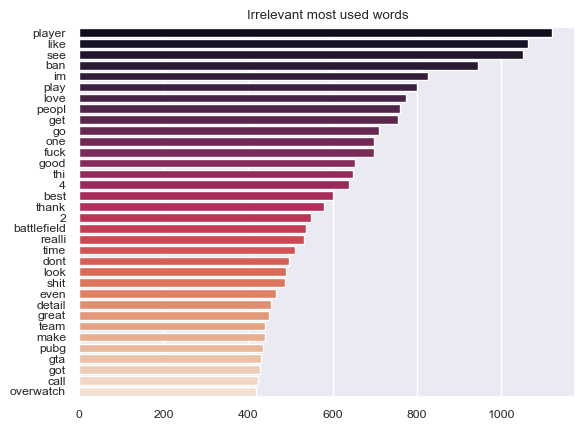

CPU times: total: 2.84 s
Wall time: 5.14 s


In [25]:
%%time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Define the word to exclude
exclude_word = "game"

sns.set(font_scale=0.8)
for inx, value in enumerate(sentiments):
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
        if word not in stop and word != exclude_word:  # Exclude the word "game"
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, orient='h', palette='rocket')
    plt.title(f'{value} most used words')
    plt.show()


Creating a column named sentiments and instead of Positive , Negative we put 1 and 0 , instead of Neutral and Irrelevant we put 2. It means that underestanding Positive and Negative reviews is much more important for use rather that neutral and Irrelevant ones.(Just for decreasing the calsses and increasing the accuracy for finding Positive and Negative ones) however , we are able to classify each one of them without mixing , but of curse the accuracy will decrease noticeably.

In [26]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [27]:
df.sample(10)

,Index,Land,Mode,Tweets,sentiments
68436,3719,Cyberpunk2077,Positive,beauti,1
66976,7069,johnson&johnson,Neutral,johnsonjohnson paus market relat toward covid1...,2
20789,12760,WorldOfCraft,Neutral,commiss two love folk wow mg,2
73991,9077,Nvidia,Irrelevant,oh yeah i use work guy second compani portfoli...,2
66446,6978,johnson&johnson,Positive,a recent report oxfam found ten among america ...,1
61937,5019,GrandTheftAuto(GTA),Irrelevant,realli love i look today feel,2
10189,12954,Xbox(Xseries),Negative,fonda45 look dirti,0
68488,3727,Cyberpunk2077,Irrelevant,due audio gtx 1060 windforc would work great n...,2
25502,4778,Google,Negative,my googl hangout work new laptop didnt restart...,0
63193,7632,MaddenNFL,Negative,eamaddennfl yall realli think famili profan i ...,0


Now , we are going to create a customer class to show len and item.

In [28]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }



# NAIVE BAYES CLASSIFIER

In [29]:
from sklearn.preprocessing import LabelEncoder

tweets = df['Tweets'].values
labels = df['sentiments'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [31]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_labels, test_labels = train_test_split(tweets, encoded_labels, stratify= encoded_labels )

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_features=3000)
X = vec.fit_transform(train_sentences)
vocab = vec.get_feature_names_out()

In [43]:
from collections import defaultdict
import math


word_counts = {}

for l in range(2):
    word_counts[l] = defaultdict(lambda:0)

for i in range(X.shape[0]):
    l = train_labels[i]
    for j in range(len(vocab)):
        word_counts[1][vocab[j]] += X[i][j]

we need to perform Laplace smoothing to handle words in the test set which are absent in the training set. We define a function ‘laplace_smoothing’ which takes the vocabulary and the raw ‘word_counts’ dictionary and returns the smoothened conditional probabilities.

In [45]:
import math

def laplace_smoothing(n_label_items, vocab, word_counts, word, text_label):
    a = word_counts[text_label][word]+1
    b = n_label_items[text_label] + len(vocab)
    return math.log(a/b)

Defining the ‘fit’ and ‘predict’ functions for our classifier.

In [46]:
def group_by_label(x, y, labels):
    data = {}
    for l in labels:
        data [l] = x[np.where(y==l)]
    return data 

def fit(x, y, labels):
    n_label_items = {}
    log_label_priors = {}
    n =len(x)

    grouped_data = group_by_label(x, y, labels)
    for l, data in grouped_data.items():
        n_label_items[l] = len(data)
        log_label_priors[l] = math.log(n_label_items[l]/n)
    return n_label_items, log_label_priors

In [ ]:
def predict(n_label_items, log_label_priors, vocab, X):
    result = []
    for text in x :
        label_scores = {l: log_label_priors[l] for l in labels}
        word = set(w_tokenizer.tokenize(text))
        